# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optiomal weights

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

# For Chromedriver
from pathlib import Path
chrome_executabel_path = str(Path.home()) + r'\Anaconda Projects\chromedriver\chromedriver'

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

In [3]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


# Gather Data

- Current Holdings
- Price Histories
- AI Alpha
- Daily Beta

## First lets see why stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

In [4]:
# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest(username, password, client_id).get_quotes(utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
current_investments_df = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
current_investments_df

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,currentDayCost,previousSessionLongQuantity,assetType,cusip,symbol,description,type
8,#---9216,0.0,352.96000,0.00,0.00,2.0,2.0,0.0,709.40,212.82,0.0,2.0,EQUITY,244199105,DE,0,0
9,#---9216,0.0,44.01929,0.00,0.00,14.0,14.0,0.0,607.88,182.36,0.0,14.0,EQUITY,46284V101,IRM,0,0
10,#---9216,0.0,68.24000,-1.71,-0.27,9.0,9.0,0.0,643.50,193.05,0.0,9.0,EQUITY,90184L102,TWTR,0,0
11,#---9216,0.0,311.60000,-1.22,-0.19,2.0,2.0,0.0,640.30,192.09,0.0,2.0,EQUITY,482480100,KLAC,0,0
12,#---9216,0.0,304.55500,0.00,0.00,2.0,2.0,0.0,613.36,184.01,0.0,2.0,EQUITY,701094104,PH,0,0
14,#---9216,0.0,661.64000,6.81,1.06,1.0,1.0,0.0,650.19,260.08,0.0,1.0,EQUITY,88160R101,TSLA,0,0
15,#---9216,0.0,47.42000,0.00,0.00,13.0,13.0,0.0,615.03,184.51,0.0,13.0,EQUITY,125269100,CF,0,0
16,#---9216,0.0,255.11000,0.00,0.00,2.0,2.0,0.0,506.14,151.84,0.0,2.0,EQUITY,294429105,EFX,0,0
17,#---9216,0.0,0.21397,0.00,0.00,5000.0,5000.0,0.0,888.50,0.00,0.0,5000.0,EQUITY,Q3860H107,FGPHF,0,0


In [5]:
holdings = utils.read_port_data(portfolio_file_name).set_index('symbol')
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['date']).set_index(['date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2016-07-22 to 2021-07-22
You have 435 stocks from picing
You have 435 stocks from alpha
You have 253 of daily betas


In [6]:
alpha_vectors[list(daily_betas.keys())[0]:]

,A,AAP,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,...,WY,WYNN,XEL,XLNX,XOM,XYL,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-07-22,-0.040126,0.044430,-0.079850,0.021295,-0.033527,-0.049705,-0.046516,-0.041552,-0.023661,-0.033831,...,0.027195,0.049767,-0.055479,-0.025858,0.024707,-0.005247,0.029711,-0.023474,0.042801,-0.043702
2020-07-23,-0.029098,0.039911,-0.078809,0.020350,-0.031775,-0.087845,-0.051866,-0.039771,-0.032018,-0.032448,...,0.034261,0.049605,-0.053862,-0.027370,0.020400,-0.005109,0.024912,-0.022225,0.045203,-0.035510
2020-07-24,-0.030075,0.029489,-0.080188,0.019689,-0.034774,-0.069804,-0.052698,-0.039673,-0.028528,-0.035213,...,0.035306,0.043527,-0.048486,-0.028366,0.021418,-0.005035,0.010632,-0.019645,0.048817,-0.038771
2020-07-27,-0.026472,0.030887,-0.078054,0.019553,-0.037746,-0.064523,-0.054146,-0.037021,-0.024047,-0.028125,...,0.034478,0.042692,-0.054896,-0.032241,0.021433,-0.005103,0.009012,-0.020635,0.053702,-0.034994
2020-07-28,-0.027313,0.029193,-0.042906,0.022046,-0.037074,-0.044761,-0.051990,-0.034787,-0.019509,-0.029878,...,0.034148,0.037580,-0.058004,-0.031665,0.019686,-0.011335,0.006033,-0.020824,0.054894,-0.029626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,-0.035816,-0.000853,-0.019073,-0.014034,-0.022449,-0.000273,0.031825,-0.027186,-0.020538,-0.033490,...,0.013511,0.043172,-0.013599,0.037193,0.043006,-0.061228,-0.031059,0.020463,0.044553,-0.021661
2021-07-19,-0.036626,-0.001373,-0.054640,-0.015738,-0.016475,0.001079,0.032559,-0.026372,-0.015678,-0.036012,...,0.019190,0.056792,-0.013823,0.032101,0.041597,-0.059681,-0.029313,0.020422,0.042120,-0.021263
2021-07-20,-0.036258,-0.016264,-0.076422,-0.014980,-0.014675,0.001618,0.032513,-0.027978,-0.010690,-0.036731,...,0.025172,0.053611,-0.012082,0.043286,0.034339,-0.055273,-0.024646,0.025583,0.054609,-0.024342


In [7]:
daily_betas.keys()

dict_keys(['07/22/2020', '07/23/2020', '07/24/2020', '07/27/2020', '07/28/2020', '07/29/2020', '07/30/2020', '07/31/2020', '08/03/2020', '08/04/2020', '08/05/2020', '08/06/2020', '08/07/2020', '08/10/2020', '08/11/2020', '08/12/2020', '08/13/2020', '08/14/2020', '08/17/2020', '08/18/2020', '08/19/2020', '08/20/2020', '08/21/2020', '08/24/2020', '08/25/2020', '08/26/2020', '08/27/2020', '08/28/2020', '08/31/2020', '09/01/2020', '09/02/2020', '09/03/2020', '09/04/2020', '09/08/2020', '09/09/2020', '09/10/2020', '09/11/2020', '09/14/2020', '09/15/2020', '09/16/2020', '09/17/2020', '09/18/2020', '09/21/2020', '09/22/2020', '09/23/2020', '09/24/2020', '09/25/2020', '09/28/2020', '09/29/2020', '09/30/2020', '10/01/2020', '10/02/2020', '10/05/2020', '10/06/2020', '10/07/2020', '10/08/2020', '10/09/2020', '10/12/2020', '10/13/2020', '10/14/2020', '10/15/2020', '10/16/2020', '10/19/2020', '10/20/2020', '10/21/2020', '10/22/2020', '10/23/2020', '10/26/2020', '10/27/2020', '10/28/2020', '10/29/20

## Generate Daily Optimal Portfolios using 1 year of alpha and beta

This first strategy is to use 2 day returns and optimize the portfolio daily.

The second stragety is to use last day of the month returns and to optimize the portfolio monthly (or 20 day returns).

Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [8]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

risk_cap = 0.10
weights_max = 0.20
weights_min = 0.0

In [9]:
holding_weights = utils.get_portfolio_weights(holdings).squeeze()

In [10]:
returns = alpha_factors.FactorReturns(price_histories).factor_data

In [11]:
dlyreturn_n_days_delay = 2
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
delayed_returns.head()

ticker,A,AAP,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,...,WY,WYNN,XEL,XLNX,XOM,XYL,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-07-23 00:00:00+00:00,0.025616,-0.002992,0.000515,0.019171,0.010456,0.008454,0.015656,0.031492,0.000950,0.001992,...,0.051140,-0.037756,-0.005466,0.039629,0.014629,0.013511,0.000969,0.012369,-0.036952,0.018548
2020-07-24 00:00:00+00:00,-0.020461,-0.004368,-0.004642,-0.012536,-0.001301,-0.005118,-0.011135,-0.003200,0.010859,0.006362,...,-0.008405,0.037211,0.012658,-0.018902,-0.011870,-0.012300,-0.000596,-0.007934,-0.004639,-0.006419
2020-07-27 00:00:00+00:00,0.018712,0.013723,0.003097,0.014176,0.026289,0.009853,0.009303,0.018029,0.007718,-0.067192,...,0.039574,0.025832,0.005252,0.028314,0.010962,0.037362,0.039605,0.009798,0.033829,0.010969
2020-07-28 00:00:00+00:00,-0.012123,0.030958,-0.010049,-0.000635,-0.009704,-0.001784,0.005896,-0.010521,0.010199,-0.031335,...,0.001762,0.014897,0.003921,0.036874,-0.050302,-0.032932,-0.009213,0.004009,-0.017839,0.010246
2020-07-29 00:00:00+00:00,0.004161,-0.018020,-0.011836,0.003440,-0.008805,0.003565,0.012319,-0.012546,-0.012299,0.000150,...,-0.020993,-0.053624,0.000580,-0.041243,0.005003,-0.022893,-0.025188,0.020875,-0.009502,0.017089


In [12]:
opt_date = delayed_returns.index[0]
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
est_return = delayed_returns.loc[opt_date]

In [13]:
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

New portfolio variance is:  0.03036720


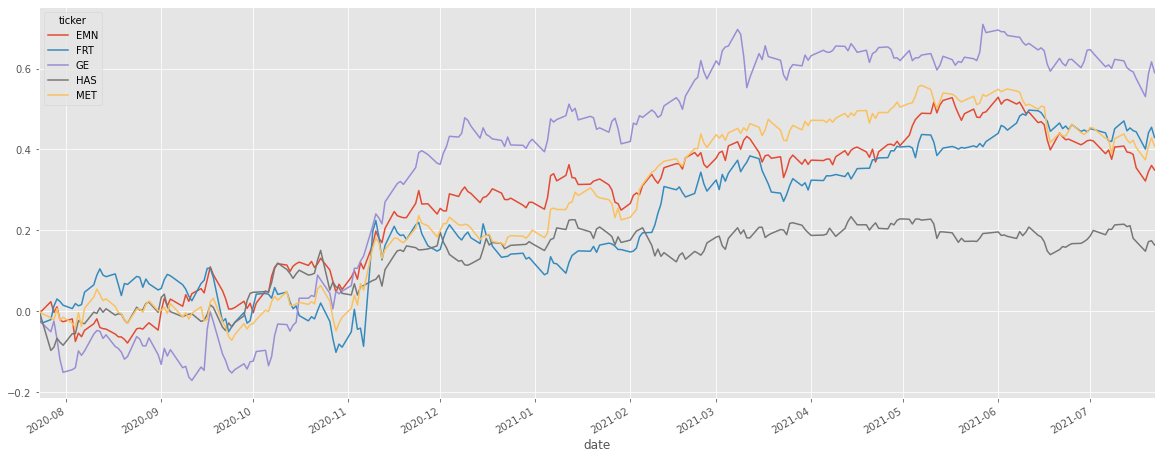

In [14]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [15]:
long_weights.index.to_list()

['EMN', 'FRT', 'GE', 'HAS', 'MET']

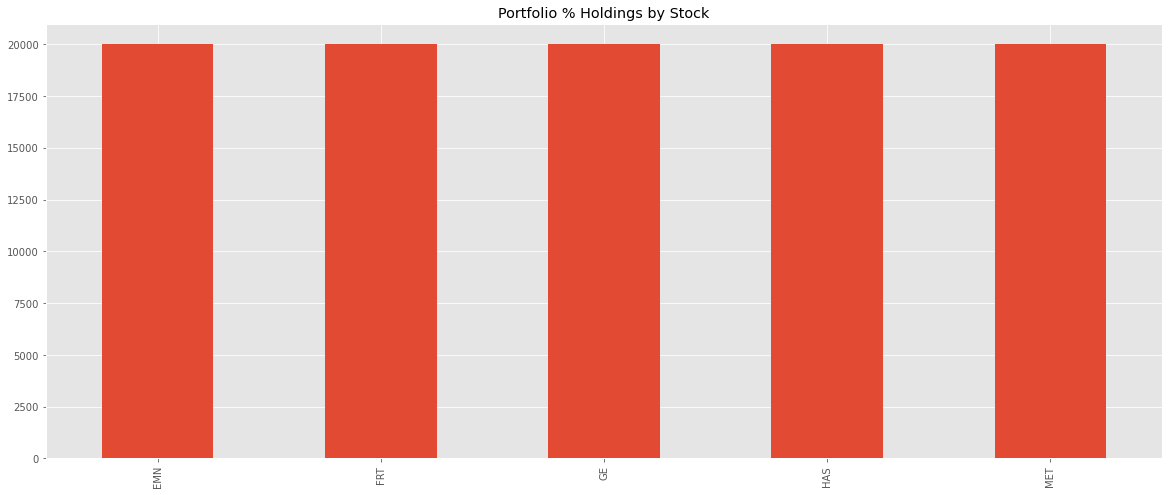

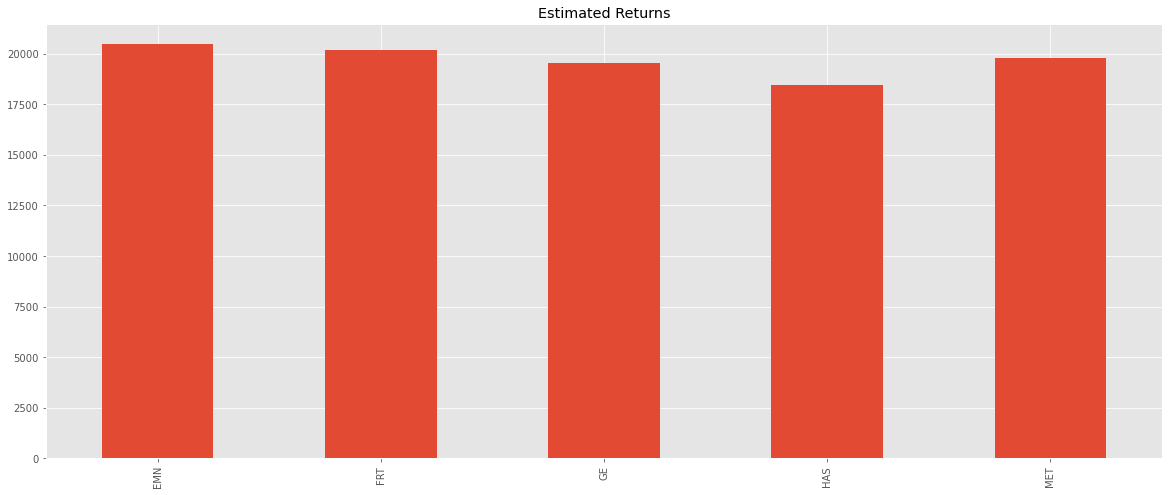

Original investment: 100000.0
New portfolio Value: 98430.69026531925


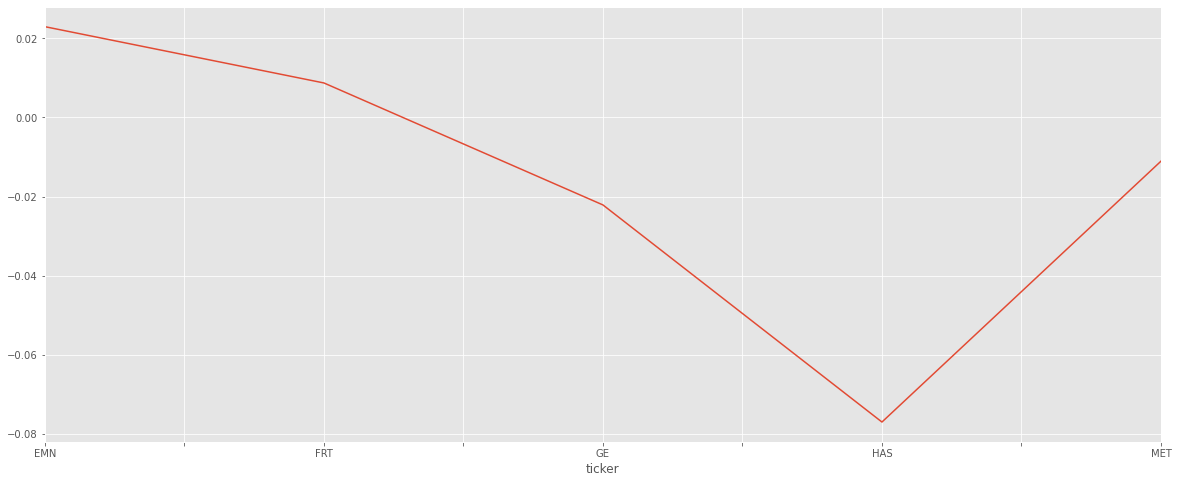

In [16]:
investment_amount = 100000
long_holdings = (long_weights['optimalWeights'] * investment_amount).round(0)
long_holdings.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.show()
new_holdings = long_holdings * (1.0 + est_return[long_holdings.index])
new_holdings.plot.bar(legend=None, title='Estimated Returns')
plt.show()
print(f'Original investment: {long_holdings.sum()}')
print(f'New portfolio Value: {new_holdings.sum()}')
est_return[long_weights.index.to_list()].plot()

In [17]:
optimal_weights

,optimalWeights
A,1.425527e-15
AAP,5.437764e-13
ABBV,-1.375061e-13
ABMD,2.537261e-13
ABT,-7.294955e-15
...,...
XYL,9.282711e-14
ZBH,2.932557e-13
ZBRA,2.720170e-14
ZION,7.299149e-13


In [18]:
np.zeros(len(delayed_returns.columns))

current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
current_holdings

,0
ticker,
A,0.0
AAP,0.0
ABBV,0.0
ABMD,0.0
ABT,0.0
...,...
XYL,0.0
ZBH,0.0
ZBRA,0.0


In [19]:
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list(), desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2020-07-23 00:00:00+00:00 to 2021-07-20 00:00:00+00:00


Dates:   0%|          | 0/250 [00:00<?, ?Portfolio Optimization/s]

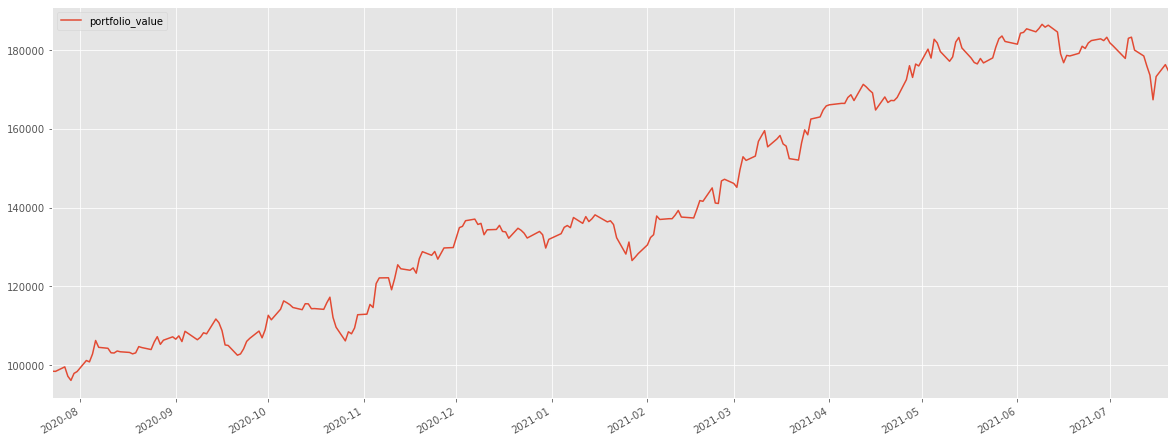

In [20]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

In [21]:
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2020-07-23 00:00:00+00:00 to 2021-07-20 00:00:00+00:00


Dates:   0%|          | 0/125 [00:00<?, ?Portfolio Optimization/s]

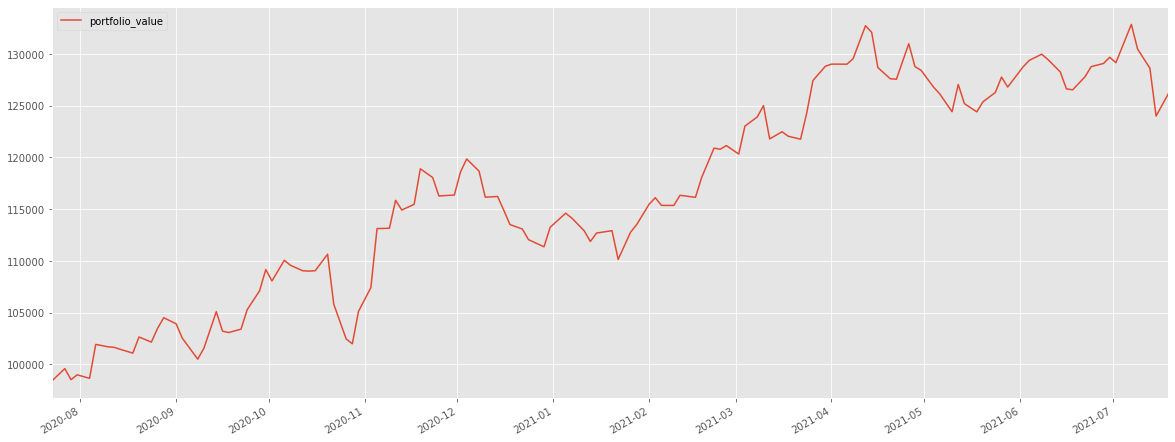

In [22]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

## 20 Day Strategy

Use 20 Day returns and optimize portfolio monthly

In [24]:
dlyreturn_n_days_delay = 20
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings
    
returns[-252:][long_weights.index.to_list()].cumsum().plot()
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

Generating 1 year Optimal Portfolios from 2020-07-23 00:00:00+00:00 to 2021-06-23 00:00:00+00:00


Dates:   0%|          | 0/12 [00:00<?, ?Portfolio Optimization/s]

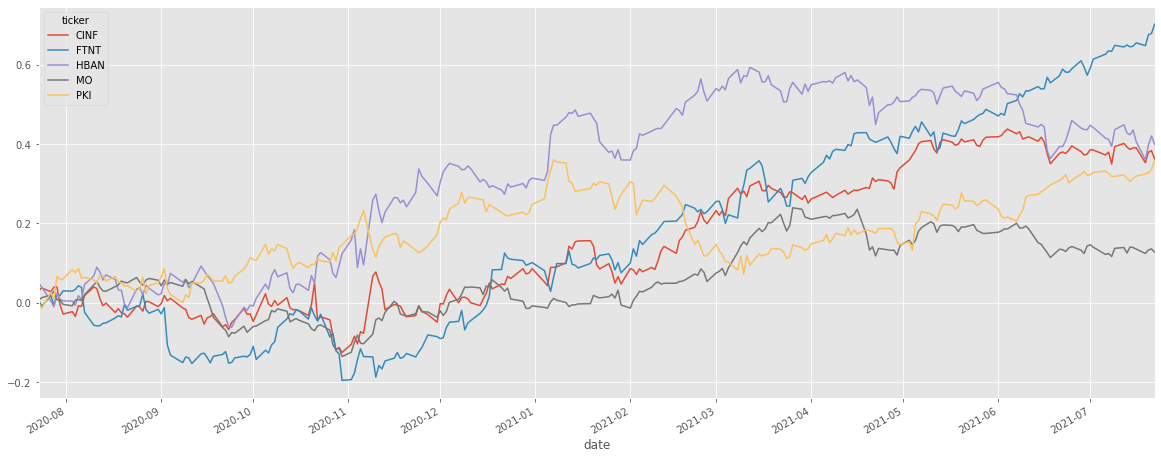

In [25]:
returns[-252:][long_weights.index.to_list()].cumsum().plot()

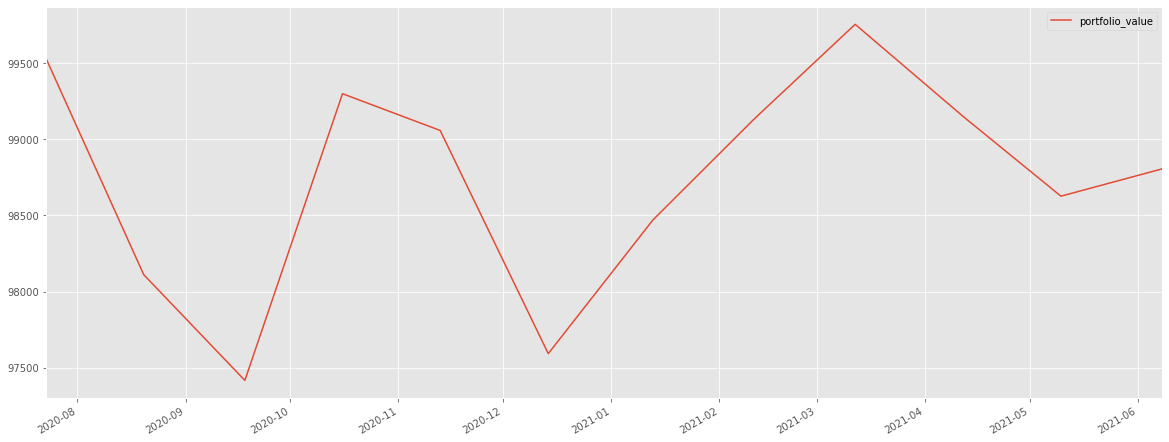

In [26]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

## 5 Day Strategy

Use 5 Day returns and optimize portfolio weekly

Generating 1 year Optimal Portfolios from 2020-07-23 00:00:00+00:00 to 2021-07-15 00:00:00+00:00


Dates:   0%|          | 0/50 [00:00<?, ?Portfolio Optimization/s]

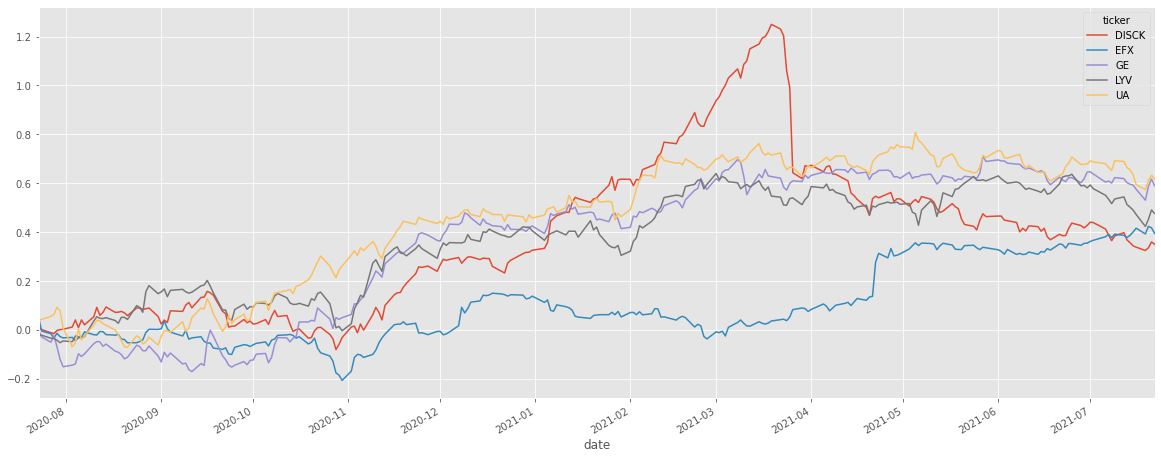

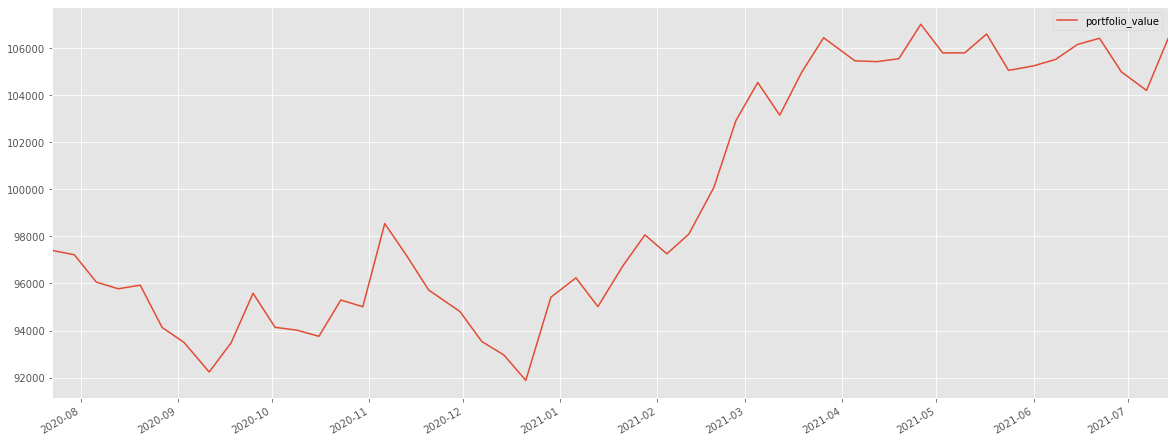

In [38]:
dlyreturn_n_days_delay = 5
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings
    
returns[-252:][long_weights.index.to_list()].cumsum().plot()
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

## Production Portfolio Optimization

Use the last day's data to determine optimal portfolio

In [27]:
opt_date = alpha_vectors.index[-1]
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

New portfolio variance is:  0.01664108


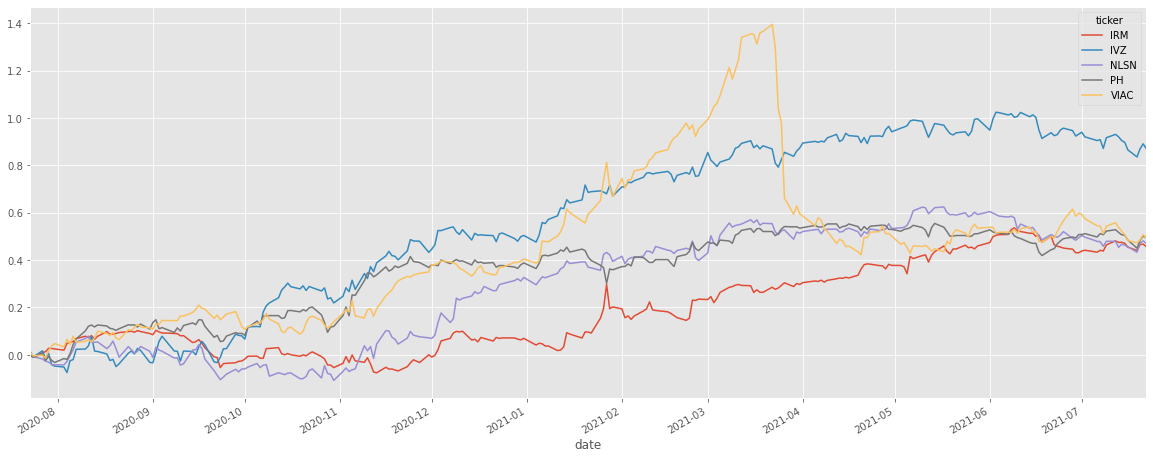

In [28]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [29]:
long_weights

,optimalWeights
IRM,0.2
IVZ,0.2
NLSN,0.2
PH,0.2
VIAC,0.2


In [30]:
investment_amount = 5000

long_quotes = amc.AmeritradeRest(username, password, client_id).get_quotes(long_weights.index.to_list())
long_holdings = (long_weights['optimalWeights'] * investment_amount).round(0)
(long_holdings / long_quotes['bidPrice'])

IRM     23.068051
IVZ     40.666938
NLSN    42.662116
PH       3.424658
VIAC    24.479804
dtype: float64

In [31]:

long_quotes

,assetType,assetMainType,cusip,symbol,description,bidPrice,bidSize,bidId,askPrice,askSize,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
IRM,EQUITY,EQUITY,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,43.35,100,K,43.95,200,...,43.42,4586,0.0,1627081200003,0.7600,0.00,0.0000,0.0,True,False
IVZ,EQUITY,EQUITY,G491BT108,IVZ,Invesco Ltd Common Stock,24.59,100,T,24.89,100,...,24.82,2333,0.0,1627081200005,0.0000,0.00,0.0000,0.0,True,False
NLSN,EQUITY,EQUITY,G6518L108,NLSN,Nielsen N.V. Ordinary Shares,23.44,200,K,24.63,200,...,24.14,1196,0.0,1627081200004,0.0000,0.00,0.0000,0.0,True,False
PH,EQUITY,EQUITY,701094104,PH,Parker-Hannifin Corporation Common Stock,292.00,100,K,326.00,100,...,306.68,570,0.0,1627081200001,0.0000,0.00,0.0000,0.0,True,False
VIAC,EQUITY,EQUITY,92556H206,VIAC,ViacomCBS Inc. - Class B Common Stock,40.85,5700,P,40.90,15100,...,40.99,2607,0.0,1627070400421,-0.2684,-0.09,-0.2196,0.0,True,False


In [32]:
long_holdings

IRM     1000.0
IVZ     1000.0
NLSN    1000.0
PH      1000.0
VIAC    1000.0
Name: optimalWeights, dtype: float64

In [33]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
parsed_and_scored_news

News Tables: 100%|████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.66News Table Items/s]


,ticker,date,time,headline,neg,neu,pos,compound
99,IRM,2020-09-05,11:32AM,Iron Mountain (IRM) Up 3.7% Since Last Earning...,0.000,1.000,0.000,0.0000
98,IRM,2020-09-08,06:00AM,Iron Mountain Announces Investment Conference ...,0.000,1.000,0.000,0.0000
97,IRM,2020-09-11,08:44AM,Iron Mountain's High Yield Isn't Worth the Risk,0.176,0.633,0.191,0.0382
96,IRM,2020-09-15,12:11PM,Iron Mountain and FutureVault Launch Transform...,0.000,1.000,0.000,0.0000
95,IRM,2020-09-23,04:30PM,Iron Mountain Wins RE100 Leadership Award for ...,0.000,0.286,0.714,0.9477
...,...,...,...,...,...,...,...,...
1,IRM,2021-07-22,12:17PM,10 Best Large Cap Dividend Stocks to Buy Now,0.000,0.656,0.344,0.6369
400,VIAC,2021-07-23,09:07AM,10 Best Large Cap Dividend Stocks to Buy Accor...,0.000,0.724,0.276,0.6369
101,IVZ,2021-07-24,08:05AM,Better Buy: Invesco QQQ or Fidelity MSCI IT In...,0.000,0.756,0.244,0.4404
100,IVZ,2021-07-26,06:20AM,Should Invesco S&P SmallCap 600 Revenue ETF (R...,0.000,1.000,0.000,0.0000


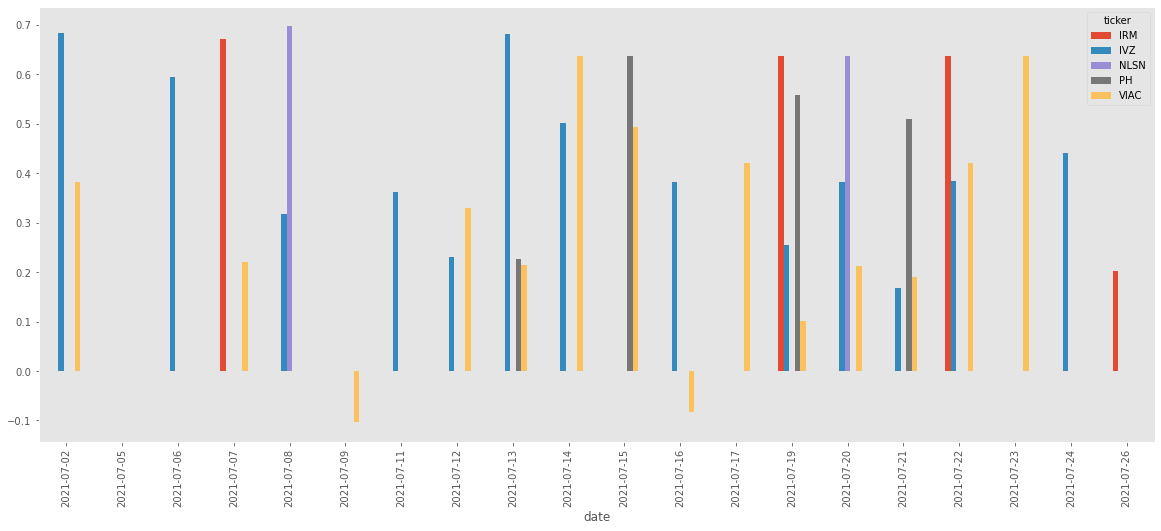

In [34]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

# Alternative optimization option using trading costs

## Adjust dates to account for trade execution

returns represents the the returns that the optimized portfolio would realize, but only after we've received the data, then chosen the optimal holdings, and allowed a day to trade into the optimal holdings.  In other words, if we use the data from daily_betas and alpha_vectors that is collected at the end of Monday, we'll use portfolio optimization to choose the optimal holdings based on this data, perhaps after hours on Monday.  Then on Tuesday, we'll have a day to execute trades to adjust the portfolio into the optimized positions.  Then on Wednesday, we'll realize the returns using those optimal holdings.

In [35]:
risk_model.factor_returns_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2020-07-23 00:00:00+00:00,-0.028285,0.124432,0.067300,-0.051723,-0.087843,0.033889,-0.054990,0.012882,0.036930,-0.057666,-0.000518,-0.037427,-0.020049,0.036702,-0.045138,0.029427,0.008009,0.014480,0.011004,-0.004945
2020-07-24 00:00:00+00:00,-0.175341,0.101242,-0.000766,-0.016851,-0.009808,0.012450,0.067679,-0.036282,-0.083345,0.049385,-0.008650,0.037453,0.016972,0.059121,-0.030156,0.089190,-0.049919,-0.004164,-0.050345,0.073751
2020-07-27 00:00:00+00:00,-0.047381,-0.246684,0.006751,-0.107609,-0.017074,0.034118,-0.081924,0.080624,0.029029,0.008674,0.108414,-0.088359,-0.072741,-0.024040,0.017665,-0.006785,-0.100948,-0.019152,-0.050644,0.004084
2020-07-28 00:00:00+00:00,-0.160795,0.173942,0.048888,0.133980,0.070219,-0.055526,0.070206,0.022509,0.002864,-0.060712,-0.028175,0.035037,0.118899,0.065119,0.029102,0.031495,0.000995,-0.006899,-0.000311,-0.086087
2020-07-29 00:00:00+00:00,0.346185,-0.175897,0.010797,-0.026423,-0.069099,0.056863,0.164647,-0.149876,-0.050685,0.003999,0.057388,0.111948,0.028246,0.191595,0.096329,0.085498,-0.065387,-0.078731,0.034059,-0.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16 00:00:00+00:00,-0.309486,-0.013753,0.106395,0.029419,0.100845,0.020524,0.008201,-0.065444,-0.023500,-0.017663,-0.001127,-0.006584,-0.023004,-0.028341,-0.032445,0.011352,-0.001621,0.004944,0.014227,-0.020811
2021-07-19 00:00:00+00:00,-0.499569,-0.018957,-0.074247,-0.033316,-0.052247,-0.041427,-0.032311,0.028538,-0.011804,-0.015702,0.014221,0.002643,0.007048,0.013206,0.043010,0.018946,0.032406,0.014273,0.011413,-0.017683
2021-07-20 00:00:00+00:00,0.427416,-0.072288,0.020494,0.098733,-0.046792,0.019215,0.044581,0.040486,-0.009258,-0.025339,0.009131,0.013935,-0.046572,-0.009038,-0.009034,0.037720,-0.007622,-0.015636,-0.024088,-0.032818


In [36]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

NameError: name 'portfun' is not defined

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)